## Inflation BPS

In [1]:
import sys; sys.path.insert(0, '..')
import pandas as pd
import scipy.stats as st
import numpy as np
from ldf.ldf import ldf
import itertools
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":20})
plt.rc('legend',fontsize=16)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
y = pd.read_excel(r"..//data//BPS//data.xlsx", sheet_name="Inflation")["Inflation"]
y_t = pd.read_excel(r"..//data//BPS//data.xlsx", sheet_name="Inflation")

In [3]:
mean = pd.read_excel(r"..//data//BPS//data.xlsx", sheet_name="Agent Mean")[["M1", "M2", "M3", "M4"]]
vol = pd.read_excel(r"..//data//BPS//data.xlsx", sheet_name="Agent Var")[["M1", "M2", "M3", "M4"]]
dof = pd.read_excel(r"..//data//BPS//data.xlsx", sheet_name="Agent dof")[["M1", "M2", "M3", "M4"]]

In [4]:
np.mean(((y - mean["M1"])**2)[-100:])

0.06341075679851398

In [5]:
np.mean(((y - mean["M2"])**2)[-100:])

0.05978642408407468

In [6]:
np.mean(((y - mean["M3"])**2)[-100:])

0.06163511601636472

In [7]:
np.mean(((y - mean["M4"])**2)[-100:])

0.08106308162237

In [8]:
np.mean(((y[:-1] - mean["M4"][1:])**2)[-100:])

0.07989632387497207

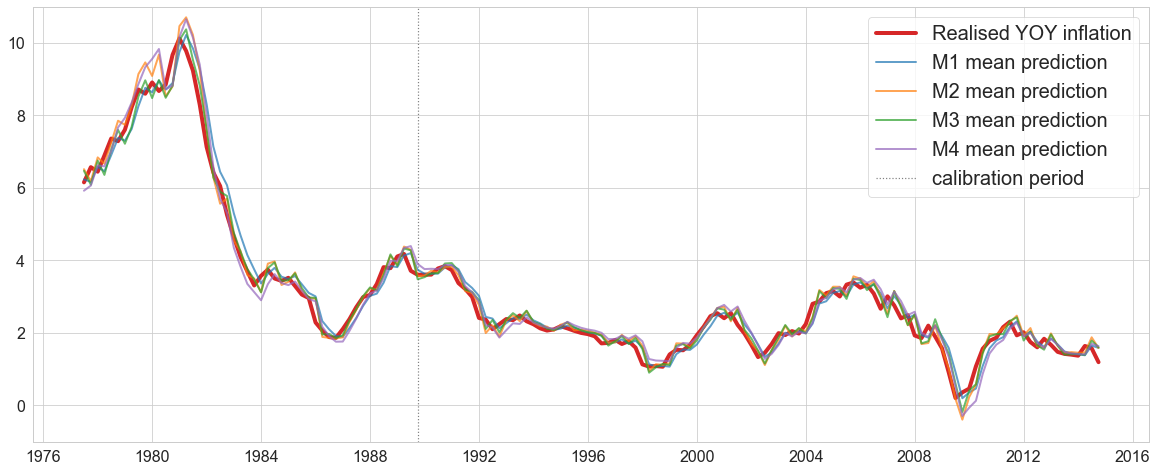

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(pd.to_datetime(y_t["Unnamed: 0"]), y, color="tab:red", lw=4, label="Realised YOY inflation")
ax.plot(pd.to_datetime(y_t["Unnamed: 0"]), mean["M1"], color="tab:blue", lw=2, label="M1 mean prediction", alpha=0.7)
ax.plot(pd.to_datetime(y_t["Unnamed: 0"]), mean["M2"], color="tab:orange", lw=2, label="M2 mean prediction", alpha=0.7)
ax.plot(pd.to_datetime(y_t["Unnamed: 0"]), mean["M3"], color="tab:green", lw=2, label="M3 mean prediction", alpha=0.7)
ax.plot(pd.to_datetime(y_t["Unnamed: 0"]), mean["M4"], color="tab:purple", lw=2, label="M4 mean prediction", alpha=0.7)
ax.vlines(pd.to_datetime(y_t["Unnamed: 0"])[49], ymin=-1, ymax=12, color="grey", ls="dotted", label="calibration period")
ax.set_ylim(-1, 11)
ax.legend();

In [10]:
log_lik_1 = np.asarray([st.t(loc=mean["M1"].to_numpy()[i], scale=np.sqrt(vol["M1"].to_numpy()[i]), df=d).logpdf(y[i]) for i, d in enumerate(dof["M1"].to_numpy())])
log_lik_2 = np.asarray([st.t(loc=mean["M2"].to_numpy()[i], scale=np.sqrt(vol["M2"].to_numpy()[i]), df=d).logpdf(y[i]) for i, d in enumerate(dof["M2"].to_numpy())])
log_lik_3 = np.asarray([st.t(loc=mean["M3"].to_numpy()[i], scale=np.sqrt(vol["M3"].to_numpy()[i]), df=d).logpdf(y[i]) for i, d in enumerate(dof["M3"].to_numpy())])
log_lik_4 = np.asarray([st.t(loc=mean["M4"].to_numpy()[i], scale=np.sqrt(vol["M4"].to_numpy()[i]), df=d).logpdf(y[i]) for i, d in enumerate(dof["M4"].to_numpy())])

### Matlab results

In [11]:
E_BPS = loadmat(r"..//data//BPS//E_BPS.mat")["E_BPS"]
V_BPS = loadmat(r"..//data//BPS//V_BPS.mat")["V_BPS"]
log_lik_BPS = np.zeros((E_BPS.shape))
for j in range(E_BPS.shape[1]):
    log_lik_BPS[:,j] = st.t(loc=E_BPS[:,j], scale=np.sqrt(V_BPS[:,j]), df=100).logpdf(y[j+1])

C:\Users\BearButis\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:1877: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [12]:
np.mean((E_BPS.mean(axis=0)[49:] - y[50:])**2)

0.05113087787044645

In [13]:
E_BPS.mean(axis=0)[49]

3.587447870029982

In [14]:
E_BPS.mean(axis=0)[49]

3.587447870029982

In [15]:
np.log(pd.DataFrame(np.exp(log_lik_BPS)).mean(axis=0))[-100:].mean()

0.06103255960328974

In [16]:
np.log(pd.DataFrame(np.exp(log_lik_BPS)).mean(axis=0))[-100:].sum()

6.103255960328972

In [17]:
np.sum(log_lik_1[-100:] - np.log(pd.DataFrame(np.exp(log_lik_BPS)).mean(axis=0))[-100:])

-13.874388728093226

In [18]:
np.sum(log_lik_2[-100:] - np.log(pd.DataFrame(np.exp(log_lik_BPS)).mean(axis=0))[-100:])

-8.578986484405931

In [19]:
np.sum(log_lik_3[-100:] - np.log(pd.DataFrame(np.exp(log_lik_BPS)).mean(axis=0))[-100:])

-9.072849487000767

In [20]:
np.sum(log_lik_4[-100:] - np.log(pd.DataFrame(np.exp(log_lik_BPS)).mean(axis=0))[-100:])

-22.753963959433435

### Averaging

In [21]:
log_lik = pd.DataFrame([log_lik_1, log_lik_2, log_lik_3, log_lik_4]).to_numpy() #

### Model averaging

In [22]:
c= 10**(-20)
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001])

### 2-level LDF(softmax, argmax)

In [23]:
res_ldf = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
ldfa_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-100:].mean(axis=1), res_ldf["logscores"][:,-100:].sum(axis=1)]).T
ldfa_df.style.format("{:.2f}")

,0,1,2
0,1.00,-0.03,-3.34
1,0.99,-0.03,-2.95
2,0.95,-0.03,-3.46
3,0.90,-0.04,-4.10
4,0.80,-0.04,-4.31
5,0.70,-0.04,-4.08
6,0.60,-0.04,-3.70
7,0.50,-0.03,-3.30
8,0.40,-0.03,-3.14
9,0.30,-0.04,-3.55


### 2-level LDF(softmax, softmax)

In [24]:
res_ldf = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-100:].mean(axis=1), res_ldf["logscores"][:,-100:].sum(axis=1)]).T
ldfs_df.style.format("{:.2f}")

,0,1,2
0,1.00,-0.03,-2.76
1,0.99,-0.02,-2.44
2,0.95,-0.02,-2.29
3,0.90,-0.02,-2.47
4,0.80,-0.03,-2.55
5,0.70,-0.03,-2.57
6,0.60,-0.03,-2.58
7,0.50,-0.03,-2.58
8,0.40,-0.03,-2.58
9,0.30,-0.03,-2.58


### 1-level LDF(softmax) (DMA)

In [25]:
res_dma = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["softmax"], c=c)
res_dma_df = pd.DataFrame([discount_factors, res_dma["logscores"][:,-100:].mean(axis=1), res_dma["logscores"][:,-100:].sum(axis=1)]).T
res_dma_df.style.format("{:.2f}")

,0,1,2
0,1.00,-0.03,-2.97
1,0.99,-0.03,-2.88
2,0.95,-0.02,-2.40
3,0.90,-0.03,-2.73
4,0.80,-0.03,-3.07
5,0.70,-0.03,-3.11
6,0.60,-0.03,-3.09
7,0.50,-0.03,-3.04
8,0.40,-0.03,-3.00
9,0.30,-0.03,-2.98


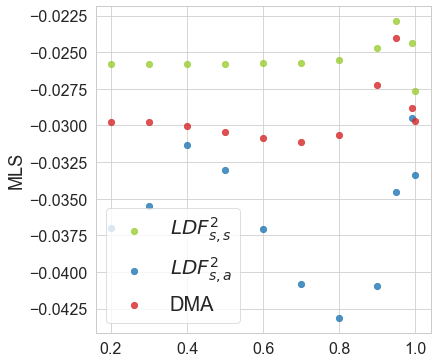

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(ldfs_df[0].to_list()[:-1], ldfs_df[1].to_list()[:-1], marker='o', color='yellowgreen', label="$LDF_{s, s}^2$", s=40, alpha=0.8)
ax.scatter(ldfa_df[0].to_list()[:-1], ldfa_df[1].to_list()[:-1], marker='o', color='tab:blue', label="$LDF_{s, a}^2$", s=40, alpha=0.8)
ax.scatter(res_dma_df[0].to_list()[:-1], res_dma_df[1].to_list()[:-1], marker='o', color='tab:red', label="DMA", s=40, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.legend(loc="lower left");

In [28]:
K = log_lik.shape[0]
n = 2
comb = list(set(itertools.combinations(np.arange(K), n)))
comb = [list(t) for t in comb]

In [33]:
rolling_window_length = 20
forecasts_lik = pd.DataFrame(np.exp(log_lik))
avg_forecasts_loglik = pd.DataFrame(np.asarray([np.log(forecasts_lik.loc[c].mean()) for c in comb]))
max_idx = avg_forecasts_loglik.rolling(rolling_window_length, min_periods=rolling_window_length, axis=1).mean().idxmax()
best_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j+1] for idx, j in zip(max_idx[19:], avg_forecasts_loglik.columns[19:-1])])

In [46]:
np.unique(max_idx[50:].astype(int), return_counts=True)

(array([0, 1, 4]), array([35, 49, 16], dtype=int64))

In [34]:
print(best_loglik[30:].mean(), best_4_loglik[30:].sum())

-0.008683921501766115 -0.8683921501766115
